# Timeseries of GPM precipitation accumulation co-located with Colorado Landslide events

## Author: Jacquelyn Witte

In [1]:
import os
from glob import glob

import earthpy as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

#### Change directory to where all the Capstone data reside

In [2]:
data_dir = os.path.join(et.io.HOME,
                        'earth-analytics',
                        'data')
os.chdir(data_dir)

#### Define the Global Landslide Catalog (GLC)

In [3]:
glc_file = os.path.join('capstone', 'landslide', 'nasa.glc.export.csv')
os.path.exists(glc_file) 

True

#### Read and subset to Colorado Landslides

In [4]:
# Read the GLC file
glc = pd.read_csv(glc_file)

glc_co = glc[(glc['country_code'] == 'US') & (
                                glc['admin_division_name'] == 'Colorado') & (
                                glc['landslide_trigger'] != 'freeze_thaw') &(
                            glc['landslide_trigger'] != 'snowfall_snowmelt')
            ]
# covert to datetime
glc_co['date'] = pd.to_datetime(glc_co['event_date'])
glc_co = glc_co.set_index('date').sort_index()
glc_co.head()

/var/folders/62/hcc5vcxn7rq_26dztbs26rfm000zzf/T/ipykernel_56290/2038222407.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glc_co['date'] = pd.to_datetime(glc_co['event_date'])


,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
date,,,,,,,,,,,,,,,,,,,,,
2007-06-01,Sky-Hi News,http://www.skyhidailynews.com/news/13393638-11...,6253,6/1/07 0:00,NaN,Granby landfill,"All in all, the county has spent over $7 milli...",Granby landfill,5km,landslide,...,US,Colorado,1864.0,Granby,5.53226,10/17/14 19:11,11/20/17 15:17,2/15/18 15:51,-105.8752,40.0929
2007-08-14,Telluride Daily Planet,http://www.telluridegateway.com/articles/2007/...,185,8/14/07 0:00,NaN,"Tellride, CO, Hwy 145",Tues afternoon 4pm,"Tellride, CO, Hwy 145",10km,mudslide,...,US,Colorado,2475.0,Meeker,10.87949,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.8818,39.9425
2007-09-06,Craigdailypress.com,http://www.craigdailypress.com/news/2007/sep/0...,238,9/6/07 0:00,NaN,"River and Mt Warner Road, Steamboat Springs, CO","slide 75 feet down hill carrying trees, etc. o...","River and Mt Warner Road, Steamboat Springs, CO",1km,mudslide,...,US,Colorado,12088.0,Steamboat Springs,2.63588,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.8295,40.4613
2007-09-17,KJCT news,http://kjct8.com/Global/story.asp?S=7085534,268,9/17/07 0:00,NaN,"I-70 between New Castle and Silt, Colorado",mudslides and flooding on road in early and mi...,"I-70 between New Castle and Silt, Colorado",5km,mudslide,...,US,Colorado,4518.0,New Castle,4.25758,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-107.5798,39.5542
2008-04-13,vaildaily,http://www.vaildaily.com/article/20080428/NEWS...,499,4/13/08 0:00,NaN,U.S. Highway 6 between Kayak Crossing apartmen...,"A mudslide buried a lane, crushed a metal reta...",U.S. Highway 6 between Kayak Crossing apartmen...,5km,mudslide,...,US,Colorado,6447.0,Avon,3.03321,4/1/14 0:00,11/20/17 15:17,2/15/18 15:51,-106.4879,39.6250


In [5]:
glc_co.columns

Index(['source_name', 'source_link', 'event_id', 'event_date', 'event_time',
       'event_title', 'event_description', 'location_description',
       'location_accuracy', 'landslide_category', 'landslide_trigger',
       'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count',
       'storm_name', 'photo_link', 'notes', 'event_import_source',
       'event_import_id', 'country_name', 'country_code',
       'admin_division_name', 'admin_division_population',
       'gazeteer_closest_point', 'gazeteer_distance', 'submitted_date',
       'created_date', 'last_edited_date', 'longitude', 'latitude'],
      dtype='object')

#### Read the GPM data
- Created from `output_gpm_2007_2016.ipynb` notebook

In [125]:
gpm_nc = os.path.join('capstone', 'gpm', 'gpm_all_saved_on_disk.nc')
gpm_xr = xr.open_dataset(gpm_nc).squeeze()
print(gpm_xr.dims)
gpm_xr

Frozen({'lon': 76, 'lat': 45, 'time': 3651, 'bnds': 2})


<xarray.Dataset>
Dimensions:                    (lon: 76, lat: 45, time: 3651, bnds: 2)
Coordinates:
  * lon                        (lon) float32 -109.3 -109.2 ... -101.9 -101.8
  * lat                        (lat) float32 36.85 36.95 37.05 ... 41.15 41.25
  * time                       (time) datetime64[ns] 2007-01-01 ... 2016-12-31
Dimensions without coordinates: bnds
Data variables:
    time_bnds                  (time, bnds) datetime64[ns] ...
    precipitationCal           (time, lon, lat) float32 ...
    precipitationCal_cnt       (time, lon, lat) int8 ...
    precipitationCal_cnt_cond  (time, lon, lat) int8 ...
    HQprecipitation            (time, lon, lat) float32 ...
    HQprecipitation_cnt        (time, lon, lat) int8 ...
    HQprecipitation_cnt_cond   (time, lon, lat) int8 ...
    randomError                (time, lon, lat) float32 ...
    randomError_cnt            (time, lon, lat) int8 ...
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.9.8 (https://mpimet.mpg...
    Conventions:     CF-1.6
    BeginDate:       2007-01-01
    BeginTime:       00:00:00.000Z
    EndDate:         2007-01-01
    EndTime:         23:59:59.999Z
    ...              ...
    InputPointer:    3B-HHR-L.MS.MRG.3IMERG.20070101-S000000-E002959.0000.V06...
    title:           GPM IMERG Late Precipitation L3 1 day 0.1 degree x 0.1 d...
    DOI:             10.5067/GPM/IMERGDL/DAY/06
    ProductionTime:  2019-08-21T13:20:13.605Z
    history_L34RS:   'Created by L34RS v1.4.2 @ NASA GES DISC on April 18 202...
    CDO:             Climate Data Operators version 1.9.8 (https://mpimet.mpg...

#### Do a demo plot as a sanity check
- <u>NOTE</u> The actual dimensions are `[time, lon, lat]`
- The variable we want is named `precipitationCal`
    - long_name : Daily accumulated precipitation (combined microwave-IR) estimate
    - units : mm

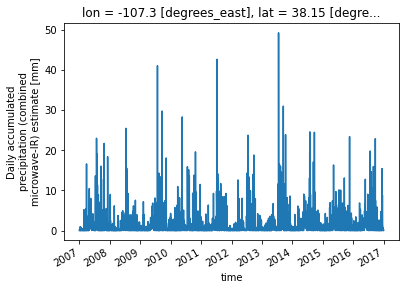

In [18]:
gpm_xr['precipitationCal'][:,20,13].plot()

#### Test the code to match a single co-located Landslide event using nearest neighbor method

In [129]:
test = gpm_xr['precipitationCal'].sel(indexers={'time':glc_co.index[0], 
                  'lon':glc_co.longitude[0],
                  'lat':glc_co.latitude[0]},
                method="nearest")
print(glc_co.index[0], glc_co.longitude[0], glc_co.latitude[0])
test['time'].values, test['lon'].values, test['lat'].values

2007-06-01 00:00:00 -105.8752 40.0929


(numpy.datetime64('2007-06-01T00:00:00.000000000'),
 array(-105.85, dtype=float32),
 array(40.05, dtype=float32))

#### Test that we know how to retrieve the precipitation time series going back 30 days

In [20]:
test = gpm_xr['precipitationCal'].sel(indexers={
                'time': pd.date_range(glc_co.index[0], periods=30, freq='-1D'),
                'lon': glc_co.longitude[0],
                'lat': glc_co.latitude[0]},
                method="nearest")
test

<xarray.DataArray 'precipitationCal' (time: 30)>
array([6.478293e-02, 6.615309e-01, 1.764799e-02, 5.893072e+00, 0.000000e+00,
       2.340568e-01, 2.230707e-01, 0.000000e+00, 4.846362e-01, 7.500689e-01,
       7.339960e-01, 1.206460e+00, 3.064084e-01, 0.000000e+00, 4.420716e-01,
       8.666319e-01, 5.000000e-03, 6.061469e-01, 1.982891e+00, 8.330569e-01,
       2.316850e-01, 6.033475e-02, 0.000000e+00, 2.945944e-01, 1.082624e-02,
       4.369069e-01, 2.509720e-01, 1.956400e+00, 2.135595e+00, 3.381911e-02],
      dtype=float32)
Coordinates:
    lon      float32 -105.8
    lat      float32 40.05
  * time     (time) datetime64[ns] 2007-06-01 2007-05-31 ... 2007-05-03
Attributes:
    long_name:  Daily accumulated precipitation (combined microwave-IR) estimate
    units:      mm

#### Plot the test

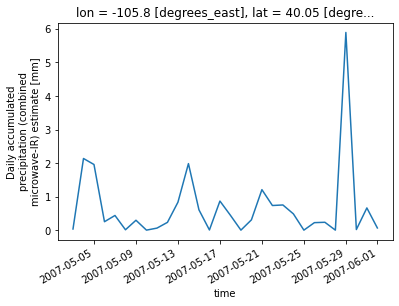

In [21]:
test.plot()

#### So far so good. Build a DataArray of these precipitation time series for all Colorado Landslides

In [102]:
gpm_date = []
gpm_id = []
gpm_ts = []
gpm_ts_list = []
for i, date in enumerate(glc_co.index):
    precip = gpm_xr['precipitationCal'].sel(indexers={
        'time': pd.date_range(date, periods=30, freq='-1D'),
        'lon': glc_co.longitude[i],
        'lat': glc_co.latitude[i]},
        method="nearest")
    gpm_ts_list.append(precip)
    gpm_ts_list[i]['landslideID'] = glc_co.event_id[i]

    # append the Landslide date
    # gpm_date.append(date)
    # append the landslide IS
    # gpm_id.append(glc_co.event_id[i])
    # append precipitation xarray timeseries
    # gpm_ts.append(precip)

# gpm_ts_xr = xr.concat(gpm_ts_list,
#                       dim='landslideID',
#                       join='left')

gpm_ts_xr = xr.concat(gpm_ts_list,
                      dim='landslideID',
                      fill_value=np.nan,
                      join='override')

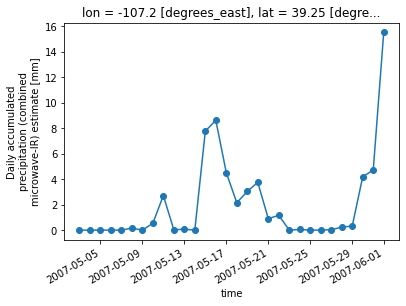

In [78]:
gpm_ts_xr[10].plot(marker='o')

#### Convert to a dataFrame for plotting/exporting

In [177]:
gpm_df = gpm_ts_xr.to_dataframe()

# Remove lat/lon columns
# gpm_df = gpm_df.drop(columns=['lon', 'lat'], axis=1)
# Reset
#gpm_df = gpm_df.reset_index().set_index('landslideID')

gpm_df[0:60]

lon        lat  precipitationCal
landslideID time                                               
6253        2007-06-01 -105.849998  40.049999          0.064783
            2007-05-31 -105.849998  40.049999          0.661531
            2007-05-30 -105.849998  40.049999          0.017648
            2007-05-29 -105.849998  40.049999          5.893072
            2007-05-28 -105.849998  40.049999          0.000000
            2007-05-27 -105.849998  40.049999          0.234057
            2007-05-26 -105.849998  40.049999          0.223071
            2007-05-25 -105.849998  40.049999          0.000000
            2007-05-24 -105.849998  40.049999          0.484636
            2007-05-23 -105.849998  40.049999          0.750069
            2007-05-22 -105.849998  40.049999          0.733996
            2007-05-21 -105.849998  40.049999          1.206460
            2007-05-20 -105.849998  40.049999          0.306408
            2007-05-19 -105.849998  40.049999          0.000000
            2007-05-18 -105.849998  40.049999          0.442072
            2007-05-17 -105.849998  40.049999          0.866632
            2007-05-16 -105.849998  40.049999          0.005000
            2007-05-15 -105.849998  40.049999          0.606147
            2007-05-14 -105.849998  40.049999          1.982891
            2007-05-13 -105.849998  40.049999          0.833057
            2007-05-12 -105.849998  40.049999          0.231685
            2007-05-11 -105.849998  40.049999          0.060335
            2007-05-10 -105.849998  40.049999          0.000000
            2007-05-09 -105.849998  40.049999          0.294594
            2007-05-08 -105.849998  40.049999          0.010826
            2007-05-07 -105.849998  40.049999          0.436907
            2007-05-06 -105.849998  40.049999          0.250972
            2007-05-05 -105.849998  40.049999          1.956400
            2007-05-04 -105.849998  40.049999          2.135595
            2007-05-03 -105.849998  40.049999          0.033819
185         2007-06-01 -107.849998  39.950008          8.881645
            2007-05-31 -107.849998  39.950008          1.378013
            2007-05-30 -107.849998  39.950008          0.000000
            2007-05-29 -107.849998  39.950008          0.000000
            2007-05-28 -107.849998  39.950008          0.000000
            2007-05-27 -107.849998  39.950008          0.000000
            2007-05-26 -107.849998  39.950008          0.000000
            2007-05-25 -107.849998  39.950008          0.000000
            2007-05-24 -107.849998  39.950008          1.700610
            2007-05-23 -107.849998  39.950008          4.506817
            2007-05-22 -107.849998  39.950008          9.924062
            2007-05-21 -107.849998  39.950008          7.881654
            2007-05-20 -107.849998  39.950008          3.316504
            2007-05-19 -107.849998  39.950008          1.014690
            2007-05-18 -107.849998  39.950008          0.261625
            2007-05-17 -107.849998  39.950008          0.000000
            2007-05-16 -107.849998  39.950008          0.000000
            2007-05-15 -107.849998  39.950008          0.000000
            2007-05-14 -107.849998  39.950008          2.325873
            2007-05-13 -107.849998  39.950008          2.739648
            2007-05-12 -107.849998  39.950008          4.469547
            2007-05-11 -107.849998  39.950008          0.057810
            2007-05-10 -107.849998  39.950008          7.679740
            2007-05-09 -107.849998  39.950008          0.014823
            2007-05-08 -107.849998  39.950008          0.788010
            2007-05-07 -107.849998  39.950008          4.267678
            2007-05-06 -107.849998  39.950008          2.936197
            2007-05-05 -107.849998  39.950008          0.473900
            2007-05-04 -107.849998  39.950008          2.500918
            2007-05-03 -107.849998  39.950008          0.000000

#### Add a count of 30 days of precipitation measurements for each landslide event. This will help in plotting.

In [192]:
ndays = np.arange(start=-30, stop=0, step=1)
#(np.arange(30)+1)*-1

In [193]:
pd.set_option('display.max_rows', 100)
print(len(gpm_df['precipitationCal'])/30)

cnts = []
accum = []
for i in range(0, int(len(gpm_df['precipitationCal'])/30)): 
    # cnts.extend(np.arange(30)+1)
    cnts.extend(ndays)

gpm_df['days'] = cnts
#gpm_df[0:60]

140.0


#### Calculated the cumulative precipitation

In [194]:
accum = []
for i, df in gpm_df.groupby("landslideID"):
    accum.extend(df['precipitationCal'].cumsum().values)

gpm_df['precip_accum'] = accum
#gpm_df[0:60]

[Text(0.5, 0, 'Days until rainfall-landslide event'),
 Text(0, 0.5, 'Precipitation [mm]'),
 Text(0.5, 1.0, 'GPM Cumultive Daily Rainfall')]

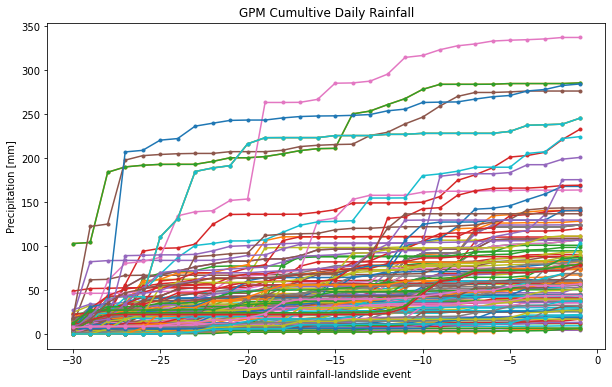

In [195]:
fig, ax = plt.subplots(figsize=(10, 6), sharex=True, sharey=True)

for id, df in gpm_df.groupby("landslideID"):
    ax.plot(df.days, df.precip_accum, marker='.')

#ax.invert_xaxis()
ax.set(xlabel='Days until rainfall-landslide event',
       ylabel='Precipitation [mm]',
       title='GPM Cumultive Daily Rainfall')

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'Precipitation [mm]'),
 Text(0.5, 1.0, 'GPM Daily Rainfall')]

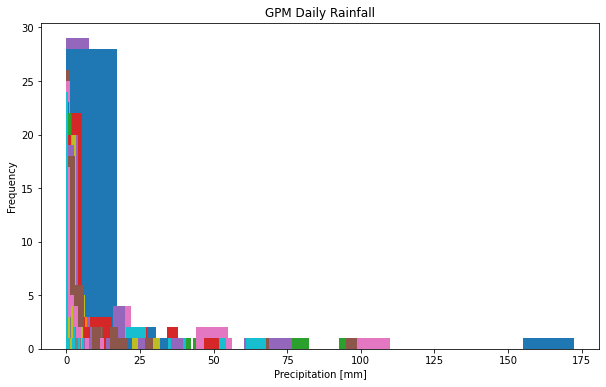

In [119]:
fig, ax = plt.subplots(figsize=(10, 6),sharex=True, sharey=True)

for id, df in gpm_df.groupby("landslideID"):
    ax.hist(df.precipitationCal)

ax.set(ylabel='Frequency',
       xlabel='Precipitation [mm]',
       title='GPM Daily Rainfall')

<AxesSubplot:>

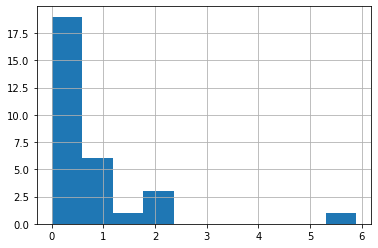

In [112]:
gpm_df['precipitationCal'][0:30].hist()